In [2]:
# Standard imports
import copy
import itertools

# Scientific computing imports
import numpy
import matplotlib.pyplot as plt
import networkx as nx
import pandas
import collections
from collections import Iterable
from bisect import bisect
from networkx.algorithms.flow import edmonds_karp
from random import choice

# Visualization imports
import matplotlib.cm as cm
%matplotlib inline

import seaborn; seaborn.set()

Setting up network
colony: 0
(0, 0) failures= 0
(1, 0) failures= 1
generation failures 1
Pareto front of generation 1 : [(0.425, 433.4358053598395), (0.35, 144.94098494113027)] 0
colony: 0
(0, 0) failures= 2
(1, 0) failures= 0
generation failures 2
Pareto front of generation 2 : [(0.425, 433.4358053598395), (0.42083333333333334, 68.37244244620646)] 0
colony: 0
(0, 0) failures= 0
(1, 0) failures= 1
generation failures 1
Pareto front of generation 3 : [(0.4791666666666667, 60.17634239748911)] 0
colony: 0
(0, 0) failures= 0
(1, 0) failures= 0
generation failures 0
Pareto front of generation 4 : [(0.4791666666666667, 60.17634239748911), (0.43333333333333335, 59.98024234877176)] 0
colony: 0
(0, 0) failures= 1
(1, 0) failures= 1
generation failures 2
Pareto front of generation 5 : [(0.4791666666666667, 60.17634239748911), (0.43333333333333335, 59.98024234877176), (0.5166666666666667, 180.8330560911575)] 0
colony: 0
(0, 0) failures= 0
(1, 0) failures= 2
generation failures 2
Pareto front of g

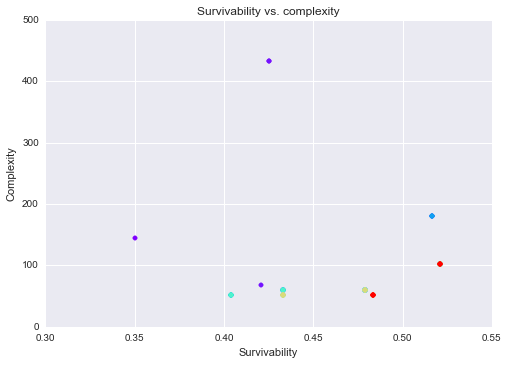

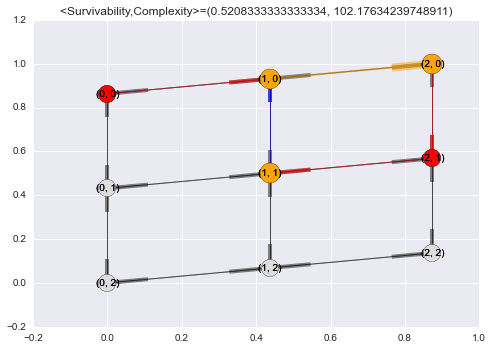

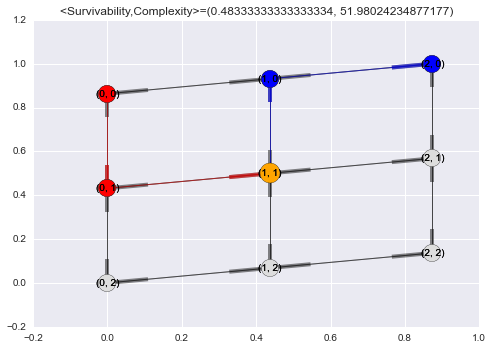

In [35]:
class Ant(object):
    """
    Ant class, which encapsulates the entire behavior of an ant.
    """
    def __init__(self,model,ant_id,colony_id):
    
        # Set model link and ID
        self.model = model
        self.ant_id = (ant_id,colony_id)
        
    def random_walk(self,source,sink,alpha=1.0,beta=1.0,system=0):
        #Random Walk
        #initialize method
        self.alpha=alpha
        self.beta=beta
        self.source=source
        self.sink=sink
        self.system=system
        self.g=nx.DiGraph()
        
        #initialize needed global data for heuristic
        self.capacity_list=self.get_capacity_list(self.system)
        
        #initialize start of random walk
        self.last_nodes={}
        for s in self.source:
            self.last_nodes[s]=[s]
        
        for key in self.last_nodes:
            self.g.add_node(key)
        
        #initialize walk trackers
        terminate=0
        steps=0
        consecutive_no_additions=0
        cycling=0
        sinks_included=0
        
        #start walk
        while not terminate:
            new=0 #did this step add new nodes?
                                  
            for key in self.last_nodes:
                '''
                Ant step is encompassed below
                '''
                steps+=1

                #track next nodes
                self.last_nodes_next={}
                  
                
                #Get number of branches     
                self.branch_pheromone_list=self.get_pheromone_branch(key,self.system)
                if self.g.out_degree(key): #determine if this node has already been visited
                    existing=1 
                    if cycling==0: #if not cycling try to follow previous path
                        self.branches=self.g.out_degree(key)
                    else:
                        self.branches=1 #if cycling try and create new branch
                else:
                    existing=0
                    self.branches=self.make_decision(self.branch_pheromone_list)+1 #index of decision +1 is the number of branches chosen
                self.neighbors_chosen=[] #list other branches taken out of that node
                
                if sinks_included==1:  #if all sinks included can terminate ants
                    terminate_ant=self.make_decision(self.get_pheromone_termination(key,self.system))
                    if terminate_ant==1: #0 is do not terminate
                        self.branches=0 #this ant does not branch
                
                #continue walk for each chosen branch       
                for branch in xrange(self.branches):
                    #get neighbors
                    self.all_p_neighbors=self.get_neighbors(key)
                   
                    self.p_neighbors=list(set(self.all_p_neighbors)-set(self.neighbors_chosen))
                    #get pheromone of each edge to neighbor
                    self.edge_pheromone_list=[]
                    for self.potential_node in self.p_neighbors:
                        edge_pheromone=self.get_pheromone_edge((key,self.potential_node),self.system)
  
                        if self.potential_node in self.g.neighbors(key) and sinks_included==1: #follow established path
                            edge_pheromone*=3

                        if self.potential_node in self.last_nodes[key]: #do not go backwards if possible
                            edge_pheromone*=.001
                        self.edge_pheromone_list.append(edge_pheromone)

                    #get next node
                    self.next_node=self.p_neighbors[self.make_decision(self.edge_pheromone_list)]
                    self.neighbors_chosen.append(self.next_node) #record branch taken
                    

                    #is this node new? **could check edges too**
                    if self.next_node not in self.g.nodes():
                        new=1 
                    
                    #add node and edge
                    self.g.add_edge(key,self.next_node)

                    #get capacity pheromones
                    capacity_pheromone_list=self.get_pheromone_capacity((key,self.next_node),self.system)
                    
                    #get capacity heuristic for maintaining flow
                    cap_in=0
                    for node_key in space.g.pred[key]:
                        cap_in+=space.g.pred[key][node_key]['capacity']
                    
                    heuristic_list=[]
                    for cap in self.capacity_list:
                        if (cap_in-cap)>0:
                            heuristic_value=1.0/(1.0+abs(cap_in-cap))
                        else:
                            heuristic_value=2.0
                            
                        heuristic_list.append(heuristic_value**self.beta)
                    
                    #apply heuristic to capacity pheromones
                    self.adjusted_pheromone_list=[]
                    for j in xrange(len(capacity_pheromone_list)):
                        self.adjusted_pheromone_list.append((capacity_pheromone_list[j]**self.alpha)*heuristic_list[j]**self.beta)

                    #decide capacity
                    self.capacity_to_add=self.model.capacities[self.system][self.make_decision(self.adjusted_pheromone_list)]

                    #add capacity
                    self.g[key][self.next_node]['capacity']=self.capacity_to_add
                    
                    
                    #record node and predecessor for next step
                    if self.next_node in self.last_nodes_next:
                        self.last_nodes_next[self.next_node].append(key)
                    else:
                        self.last_nodes_next[self.next_node]=[key]

            
            #Increment cycling tracker
            if new==0:
                consecutive_no_additions+=1
            else:
                consecutive_no_additions=0
            
            sinks_included=1 #check if all sinks in the walk
            for sink_node in self.sink:
                if sink_node not in self.g.nodes():
                    sinks_included=0
            
            #If cycling, either end or force ants to explore
            if consecutive_no_additions>100:
                cycling=1
                if sinks_included==0:
                    for node in self.last_nodes_next:#if cycling encourage ants to explore
                        self.last_nodes_next[node].append(self.g.neighbors(node)) #record neighbors as predecessors
                else: #if sinks included and cycling, end
                    self.last_nodes_next={} #cut list triggering termination
            
            #Check Termination Criteria
            if not self.last_nodes_next:
                terminate=1

            self.last_nodes=self.last_nodes_next
        
        #Prune walk
        out_graph=self.prune_graph(self.g,self.sink,self.source)
        
        return  (out_graph)
    
    def prune_graph(self,graph,sinks,sources):
        """
        Removes nodes that only go out and back or are dead ends
        """
        done=0
        while not done:
            done=1
            for n in graph:
                    
                if graph.out_degree(n)==0 and (n not in sinks): #dead end, non-sink nodes
                    done=0
                    break
                
                if (graph.out_degree(n)==1) and (graph.in_degree(n)==1) and (n not in (sinks or sources)): #there and back non-critical nodes
                    neighbor=graph.neighbors(n)
                    if n in graph.neighbors(neighbor[0]):
                        done=0
                        break
            if done==0:
                graph.remove_node(n)
        
        return graph
                
    
    def get_neighbors(self,node):
        """
        Return neighbors, calling through model.
        """
        return self.model.get_ant_neighbors(node)
    
    def make_decision(self,pheromone_list):
        """
        Return decision index, based on pheromone list.
        """
        #convert pheromones to percentage
        self.percent_list = [float(i)/sum(pheromone_list) for i in pheromone_list]   
        self.cumulative_percent=numpy.cumsum(self.percent_list)

        #Choose decision index
        self.select_index=bisect(self.cumulative_percent,numpy.random.uniform(0,1,1))
  
        return self.select_index
    
    def get_capacity_list(self,system):
        """
        Returns the capacity list from the space
        """
        return self.model.capacities[system]
    
    def get_pheromone_branch(self,node,system):
        """
        Return node pheromone, calling through model.
        """    
        return self.model.get_branch_pheromone(node,self.ant_id,system)
    
    def get_pheromone_edge(self,edge,system):
        """
        Return edge pheromone, calling through model.
        """
        return self.model.get_edge_pheromone(edge,self.ant_id,system)

    def get_pheromone_capacity(self,edge,system):
        """
        Return edge pheromone, calling through model.
        """
        return self.model.get_capacity_pheromone(edge,self.ant_id,system)
    
    def get_pheromone_termination(self,node,system):
        """
        Return node pheromone, calling through model.
        """    
        return self.model.get_termination_pheromone(node,self.ant_id,system)        
    

    def __repr__(self):
        '''
        Return string representation.
        '''
        skip_none = True
        repr_string = type(self).__name__ + " ["
        except_list = "model"

        elements = [e for e in dir(self) if str(e) not in except_list]
        for e in elements:
            # Make sure we only display "public" fields; skip anything private (_*), that is a method/function, or that is a module.
            if not e.startswith("_") and eval('type(self.{0}).__name__'.format(e)) not in ['DataFrame', 'function', 'method', 'builtin_function_or_method', 'module', 'instancemethod']:
                    value = eval("self." + e)
                    if value != None and skip_none == True:
                        repr_string += "{0}={1}, ".format(e, value)

        # Clean up trailing space and comma.
        return repr_string.strip(" ").strip(",") + "]"

class Space(object):
    """
    Space class, which encapsulates the entire behavior of a single "run" ACO.
    """
    def __init__(self, size=[3,3],num_ants=2,num_colonies=1,
                 source=[[(0,0)],[(1,1)]],source_magnitude=[[5],[5]],
                 sink=[[(1,1)],[(2,0)]],sink_magnitude=[[5],[5]], sink_threshold=[[1.0],[1.0]],
                 links=[(1,0,(1,1))],capacities=[[5,10],[5,10]],edge_capacity=20, percent_removals=.5,
                 dissipation=.2,initial_pheromone=1.0,initial_termination=.5,
                 alpha=1.0,beta=1.0):
        """
        Class constructor.
        """
        # Set our model parameters
        self.size = size
        self.sink = sink
        self.sink_magnitude = sink_magnitude
        self.sink_threshold= sink_threshold #at what point is the sink not functioning
        self.source=source
        self.source_magnitude = source_magnitude
        self.links=links # format: (recieving_system,sending_system,node)
        
        #Ants
        self.num_ants=num_ants
        self.num_colonies=num_colonies
        self.dissipation=dissipation
        self.initial_pheromone=initial_pheromone
        self.capacities=capacities
        self.alpha=alpha
        self.beta=beta
        self.percent_removals=percent_removals
        self.initial_termination=initial_termination
        self.edge_capacity=edge_capacity
          
        # Set our state variables
        self.t = 0
        self.ants = []
        self.ant_graphs=[]

        # Call our setup methods to initialize space, people, and institution.
        self.setup_space()
        self.setup_ants()
        

    def setup_space(self):
        """
        Method to setup our space.
        """
        # Initialize a space with a grid network
        self.g = nx.grid_graph(dim=self.size)
        self.g=self.g.to_directed()
        
        # Set Pheromones
        print 'Setting up network'
        capacity_pheromone_list=[self.initial_pheromone]*len(self.capacities[0])*2
        capacity_pheromone_list.extend([self.initial_pheromone]*len(self.capacities[1])*2)
        for e in self.g.edges_iter():
            self.g.add_edge(e[0],e[1],max_capacity=self.edge_capacity)
            self.g.add_edge(e[0],e[1],capacity=0) #initial capacity 
            self.g.add_edge(e[0],e[1],edge_pheromone=[self.initial_pheromone]*2*2) #pheromone per edge
            self.g.add_edge(e[0],e[1],capacity_pheromone=capacity_pheromone_list) #pheromone per capacity
            
        for n in self.g.nodes_iter():
            neighbors_n=self.g.neighbors(n)
            
            branch_pheromone_list=[]
            branch_pheromone_list=[self.initial_pheromone]
            branch_pheromone_list.extend([self.initial_pheromone*.5]*(len(neighbors_n)-1))
            self.g.add_node(n,branch_pheromone=branch_pheromone_list*2*2)

            termination_pheromone_list=[self.initial_termination*0.25,self.initial_termination]*2*2
            self.g.add_node(n,termination_pheromone=termination_pheromone_list)

        # Set layout    
        self.g_layout = nx.spectral_layout(self.g)
 
        
    def setup_ants(self):
        """
        Method to setup our space.
        """       
        # First, begin by creating all ants.
        int_id=0 #set up list ID of ants
        self.ant_id_dict={} #set up dict converting ant id to list id
        for c in xrange(self.num_colonies):
            for i in xrange(self.num_ants):
                self.ants.append(Ant(model=self,ant_id=(i+1),colony_id=(c+1)))
                self.ant_id_dict[(i,c)]=int_id                
                int_id+=1
    
    def split_lists(self,input_list):
        """
        List manipulation for pheromone lists
        """       
        half = len(input_list)/2
        return input_list[:half], input_list[half:]
    
    def flatten(self,lis):
        """
        Reconstruct pheromone lists after split
        """       
        for item in lis:
            if isinstance(item, Iterable) and not isinstance(item, basestring):
                for x in self.flatten(item):
                    yield x
            else:        
                yield item
  
    def get_branch_pheromone(self,node,ant_id,system):     
        """
        Get branch decision pheromone for ant call
        """          
        ant_weight=float(ant_id[0]-1)/(self.num_ants-1)
        pheromone_full=self.g.node[node]['branch_pheromone']
        system_pheromones=[[],[]]
        system_pheromones[0],system_pheromones[1]=self.split_lists(pheromone_full)
        pheromone_1, pheromone_2=self.split_lists(system_pheromones[system])
    
        weighted_pheromone_1=[i**ant_weight for i in pheromone_1]
        weighted_pheromone_2=[i**(1-ant_weight) for i in pheromone_2]
        composite_pheromone=[weighted_pheromone_1[i]*weighted_pheromone_2[i] for i in xrange(len(weighted_pheromone_1))]

        return composite_pheromone
            
    def get_edge_pheromone(self,edge,ant_id,system):
        """
        Get edge decision pheromone for ant call
        """        
        ant_weight=float(ant_id[0]-1)/(self.num_ants-1)
        if system==1:
            pheromone_1=self.g[edge[0]][edge[1]]['edge_pheromone'][0]
            pheromone_2=self.g[edge[0]][edge[1]]['edge_pheromone'][1]
        else:
            pheromone_1=self.g[edge[0]][edge[1]]['edge_pheromone'][2]
            pheromone_2=self.g[edge[0]][edge[1]]['edge_pheromone'][3]
                
        return (pheromone_1**ant_weight)*(pheromone_2**(1-ant_weight))
    
    def get_capacity_pheromone(self,edge,ant_id,system):
        """
        Get capacity decision pheromone for ant call
        """  
        ant_weight=float(ant_id[0]-1)/(self.num_ants-1)
        pheromone_full=self.g[edge[0]][edge[1]]['capacity_pheromone']
        system_pheromones=[[],[]]
        system_pheromones[0]=pheromone_full[:len(self.capacities[0])*2]
        system_pheromones[1]=pheromone_full[len(self.capacities[0])*2:]
        pheromone_1, pheromone_2=self.split_lists(system_pheromones[system])
        
        weighted_pheromone_1=[i**ant_weight for i in pheromone_1]
        weighted_pheromone_2=[i**(1-ant_weight) for i in pheromone_2]
        composite_pheromone=[weighted_pheromone_1[i]*weighted_pheromone_2[i] for i in xrange(len(weighted_pheromone_1))]
        
        return composite_pheromone
    
    def get_termination_pheromone(self,node,ant_id,system):
        """
        Get termination decision pheromone for ant call
        """        
        ant_weight=float(ant_id[0]-1)/(self.num_ants-1)
        pheromone_full=self.g.node[node]['termination_pheromone']
        system_pheromones=[[],[]]
        system_pheromones[0],system_pheromones[1]=self.split_lists(pheromone_full)
        pheromone_1, pheromone_2=self.split_lists(system_pheromones[system])
    
        weighted_pheromone_1=[i**ant_weight for i in pheromone_1]
        weighted_pheromone_2=[i**(1-ant_weight) for i in pheromone_2]
        composite_pheromone=[weighted_pheromone_1[i]*weighted_pheromone_2[i] for i in xrange(len(weighted_pheromone_1))]
        
        return composite_pheromone 
        
    def get_ant_neighbors(self,node):
        """
        Get node neighbors for ant call
        """
        return self.g.neighbors(node)
            
    def get_path(self, ant_id,system):
        """
        Get the path of an ant based on their ID.
        """
        ant_list_id=self.ant_id_dict[ant_id]
        return self.ants[ant_list_id].random_walk(self.source[system],self.sink[system],self.alpha,self.beta,system)
    
    def flow_test(self,graph):
        """
        Calculates the flow from sources to sinks in a graph.
        
        """
        flow_graph_1=copy.deepcopy(graph[0])
        flow_graph_2=copy.deepcopy(graph[1])
        
        # Create flow graphs for testing
        #add aggregate sinks
        for i in xrange(len(self.sink[0])):
            flow_graph_1.add_edge(self.sink[0][i],'sink',capacity=self.sink_magnitude[0][i])
        
        for i in xrange(len(self.sink[1])):
            flow_graph_2.add_edge(self.sink[1][i],'sink',capacity=self.sink_magnitude[1][i])
        
        #add aggregate source
        flow_graph_1.add_node('place_holder') #fixes indexing error in maximum_flow
        for i in xrange(len(self.source[0])):
            flow_graph_1.add_edge('source',self.source[0][i],capacity=self.source_magnitude[0][i])
            
        flow_graph_2.add_node('place_holder') #fixes indexing error in maximum_flow
        for i in xrange(len(self.source[1])):
            flow_graph_2.add_edge('source',self.source[1][i],capacity=self.source_magnitude[1][i])
        
        flow_graph=[flow_graph_1,flow_graph_2]
        flow=[]
        
        # Test for cascading failures
        while True:
            #get flow values
            flow_value=[[],[]]
            flow_dict=[[],[]]
            flow_value[0], flow_dict[0] = nx.maximum_flow(flow_graph[0], 'source', 'sink')
            flow_value[1], flow_dict[1] = nx.maximum_flow(flow_graph[1], 'source', 'sink')
            flow.append(flow_value)

            failure=0
            for link in self.links: #if sink in linked nodes fails, corresponding source fails
                receiving=link[0] #system recieving flow
                sending=link[1] #system sending flow
                node=link[2]
                sending_node_index=self.sink[sending].index(node)
                sending_flow=flow_dict[sending][node]['sink']
                sending_threshold=float(self.sink_magnitude[sending][sending_node_index])*self.sink_threshold[sending][sending_node_index]
                
                failure=0
                if sending_flow < sending_threshold: #sink fails and linked source fails
                    failure=1
                    #emulate failure by cutting node off from aggregate source
                    flow_graph[receiving]['source'][node]['capacity']=0 

            if failure==0 or (len(flow)>=2 and (flow[-1]==flow[-2])): #continue until steady-state
                break
                                       
        return flow_value, flow_dict
    
    def graph_energy(self,graph):
        """
        Calculates the energy of a system graph. (not currently used)
        """
        e_val, e_vec=numpy.linalg.eig(nx.adjacency_matrix(graph.to_undirected()).todense())
    
        return sum(abs(e_val))
    
    
    def complexity_score(self,graph):
        """
        Calculates the complexity of two system graph.
        """
        sys_complexity_edge=0
        for u,v in self.g.edges():
            temp_graph=copy.deepcopy(graph)
            
            #get max_cap from space 
            edge_max=space.g[u][v]['max_capacity']
   
            edge_cap=0
            num_sys_edge=0
            for g_index in xrange(2):
                #get capacity in edge
                sys_cap=0
                if temp_graph[g_index].has_edge(u,v):
                    sys_cap+=graph[g_index][u][v]['capacity']
                    temp_graph[g_index].remove_edge(u,v)
                    num_sys_edge+=1
                edge_cap+=sys_cap
                
            cap_difference=float(edge_cap)/edge_max
            if num_sys_edge>0:
                #complexity follows functional complexity
                edge_complexity=edge_cap*2**(cap_difference*num_sys_edge)
            else:
                edge_complexity=0
                
            sys_complexity_edge+=edge_complexity
            
        sys_complexity_node=0
        for n in self.g:
            num_sys_node=0
            edge_in=0
            edge_out=0
            for g_index in xrange(2):
                #track how many edges the node supports
                if n in graph[g_index]:
                    num_sys_node+=1
                    edge_in+=graph[g_index].in_degree(n)
                    edge_out+=graph[g_index].out_degree(n)
            if num_sys_node>0:
                #complexity follows functional complexity
                node_complexity=(edge_in+edge_out)*2**num_sys_node
            else:
                node_complexity=0
            sys_complexity_node+=node_complexity
            
        sys_complexity=sys_complexity_node+sys_complexity_edge
        
        return sys_complexity
    
    def evaluate_graph(self, ant_graph):
        """
        Score graphs based on criteria.
        """
                
        #Score 1 - Flow        
        #get initial flow values
        flow_value_ini,flow_dict_ini=self.flow_test(ant_graph)
        flow_score_ini=[]
        for g_index in xrange(2):
            flow_score_ini.append(float(flow_value_ini[g_index])/sum(self.sink_magnitude[g_index]))
        
        #check if system provide initial stable flow
        for g_index in xrange(2):
            all_sink=1
            for sink_index in xrange(len(self.sink[g_index])):
                sink_flow=flow_dict_ini[g_index][self.sink[g_index][sink_index]]['sink']
                if sink_flow==0:
                    all_sink=0
            flow_score_ini[g_index]*=all_sink
    

        #Percolate and test flow
        percolation_graph=copy.deepcopy(ant_graph)
        space_graph = nx.grid_graph(dim=self.size)
        space_graph=space_graph.to_directed()
        base_percolation_graph=[]
        #create full space graph for percolation
        for g in xrange(2):
            base_percolation_graph.append(nx.compose(space_graph,percolation_graph[g]))
        #get number of removal    
        num_removals=int(numpy.rint(base_percolation_graph[0].number_of_edges()*self.percent_removals))
        
        survivability_flow=0
        survivability_function=0
        num_trials=10 #testing range
        for i in xrange(num_trials):
            percolation_graph=copy.deepcopy(base_percolation_graph)
            
            #remove edges and check flow values
            for j in xrange(num_removals):
                edge_removed=choice(percolation_graph[0].edges())
                for g_index in xrange(2):
                    percolation_graph[g_index].remove_edge(edge_removed[0],edge_removed[1])
                    percolation_graph[g_index].remove_edge(edge_removed[1],edge_removed[0])
                    
                #Check if there is a cascade and iterate.    
                flow_increment,flow_dict=self.flow_test(percolation_graph)
                function_increment=0
                for g_index in xrange(2):
                    for sink_index in xrange(len(self.sink[g_index])):
                        sink_flow=flow_dict[g_index][self.sink[g_index][sink_index]]['sink']
                        sink_threshold=self.sink_magnitude[g_index][sink_index]*self.sink_threshold[g_index][sink_index]                         
                        function_increment+=(sink_flow>=sink_threshold)
                    
                if function_increment==0: #system has failed
                    break
                else:
                    survivability_function+=function_increment

        #flow is judged by the amount of flow that gets to the aggregate sink based on the total sink magnitude
        num_sinks=len(self.sink_magnitude[0])+len(self.sink_magnitude[1])
        
        if num_removals==0:
            survivability_score_function=1
        else:
            survivability_score_function=float(survivability_function)/(num_sinks*num_removals*num_trials)

        #penalty on survivability function for less than full initial flow    
        survivability_score_function*=(flow_score_ini[0]*flow_score_ini[1])**2
        
        #Score 2 - Complexity
        complexity_score=self.complexity_score(ant_graph)
        #penalty on complexity function for less than full initial flow
        if flow_score_ini[0]*flow_score_ini[1]==0:
            complexity_score*=1000
        else:
            complexity_score*=1/(flow_score_ini[0]*flow_score_ini[1])**2
        
        return (survivability_score_function,complexity_score),flow_score_ini
    
    def dominates(self, point_1, point_2, equality_sequence):
        '''
        Calculates if a point is dominated by another point, used in simple_cull_front
        equality_sequence:= 1 is '>=',0 is '<='
        '''
        score=0
        for i in range(len(point_1)):
            if equality_sequence[i]==1 and point_1[i]>=point_2[i]:
                score+=1
            elif equality_sequence[i]==0 and point_1[i]<=point_2[i]:
                score+=1
        dom=score==len(point_1)    
        return dom    
   
    def simple_cull_front(self, inputPoints, dominates, equality_sequence):
        '''
        Basic algorithm to find the pareto front of a set of points
        min or max is determined based on equality_sequence:= 0 is min, 1 is max
        '''
        paretoPoints = set()
        candidateRowNr = 0
        dominatedPoints = set()
        while True:
            candidateRow = inputPoints[candidateRowNr]
            inputPoints.remove(candidateRow)
            rowNr = 0
            nonDominated = True
            while len(inputPoints) != 0 and rowNr < len(inputPoints):
                row = inputPoints[rowNr]
                if self.dominates(candidateRow, row,equality_sequence):
                    # If it is worse on all features remove the row from the array
                    inputPoints.remove(row)
                    dominatedPoints.add(tuple(row))
                elif self.dominates(row, candidateRow, equality_sequence):
                    nonDominated = False
                    dominatedPoints.add(tuple(candidateRow))
                    rowNr += 1
                else:
                    rowNr += 1

            if nonDominated:
                # add the non-dominated point to the Pareto frontier
                paretoPoints.add(tuple(candidateRow))

            if len(inputPoints) == 0:
                break
        return paretoPoints, dominatedPoints

    
    def ant_ranking(self, ant_graphs):
        """
        Find best Ants based on scores from evaluate_graph.
        """
        score_list=[]
        num_ants_generation=self.num_ants*self.num_colonies
        [score_list.append(graph[1]) for graph in ant_graphs] #Global Pareto
        cull_scores=score_list[:]
        equality_sequence=[1,0] #[>=,<=]
        self.paretoPoints, self.dominatedPoints=self.simple_cull_front(cull_scores,self.dominates,equality_sequence)
        self.paretoPoints=list(self.paretoPoints)

        best_ants_index=[]
        
        #match the score_list indices to the pareto front values
        for i in xrange(len(score_list)):
            if score_list[i] in self.paretoPoints:
                best_ants_index.append(i)
                
        return best_ants_index, score_list
    
    def pheromone_dissipation(self,pheromone_list,dissipation):
        """
        Updates a pheromone list with the proper increment based on system number.
        """
        return_list=[]
        for i in xrange(len(pheromone_list)):
            return_list.append(pheromone_list[i]*(1.0-dissipation))
        return return_list
    
    def pheromone_update(self,pheromone_list,increment,system,index):
        """
        Updates a pheromone list with the proper increment based on system number.
        """
        sys_list=[[],[]]
        sys_list[0],sys_list[1]=self.split_lists(pheromone_list)
        objective_sys_list=[[[],[]],[[],[]]]
        for sys in xrange(2):
            objective_sys_list[sys][0],objective_sys_list[sys][1]=self.split_lists(sys_list[sys])
        for obj in xrange(2):
            objective_sys_list[system][obj][index]+=increment[obj]
        return_list=list(self.flatten(objective_sys_list))
        return return_list
    
    def pheromone_update_capacity(self,pheromone_list,increment,system,index):
        """
        Updates a pheromone list with the proper increment based on system number.
        """
        sys_list=[[],[]]
        sys_list[0]=pheromone_list[:len(self.capacities[0])*2]
        sys_list[1]=pheromone_list[len(self.capacities[0])*2:]
        pheromone_1, pheromone_2=self.split_lists(sys_list[system])
        objective_sys_list=[[[],[]],[[],[]]]
        for sys in xrange(2):
            objective_sys_list[sys][0],objective_sys_list[sys][1]=self.split_lists(sys_list[sys])
        for obj in xrange(2):
            objective_sys_list[system][obj][index]+=increment[obj]
        return_list=list(self.flatten(objective_sys_list))
        return return_list
        
    def ant_path(self,ant_id):
        """
        Returns a feasible ant path.
        """
        full_flow=0
        ant_failures=0
        #iterate until initial satisfactory flow is created
        while full_flow==0:
            ant_graph=[[],[]]
            for g in xrange(2):
                ant_graph[g]=self.get_path(ant_id,g)

            #Evaluate Paths
            graph_score,sat_flow=self.evaluate_graph(ant_graph)
            full_flow=1
            #check if initial flow is satisfied
            if sat_flow[0]==0 or sat_flow[1]==0:
                ant_failures+=1
                full_flow=0
        
        return ant_graph, graph_score, ant_failures
    
    def update_institutions(self, ant_graphs, opt_ants, score_list, capacities):
        """
        Update institutions based on optimal ant solutions
        """
        #Get pheromones
        edge_pheromone_dict=nx.get_edge_attributes(self.g,'edge_pheromone')
        capacity_pheromone_dict=nx.get_edge_attributes(self.g,'capacity_pheromone')
        branch_pheromone_dict=nx.get_node_attributes(self.g,'branch_pheromone')
        termination_pheromone_dict=nx.get_node_attributes(self.g,'termination_pheromone')
        
        #Reduce edge pheromones by input amount
        for key in edge_pheromone_dict:
            edge_pheromone_dict[key]=self.pheromone_dissipation(edge_pheromone_dict[key], self.dissipation)
        for key in capacity_pheromone_dict:
            capacity_pheromone_dict[key]=self.pheromone_dissipation(capacity_pheromone_dict[key], self.dissipation)
        
        #Reduce node pheromones by input amount
        for key in branch_pheromone_dict:
            branch_pheromone_dict[key]=self.pheromone_dissipation(branch_pheromone_dict[key], self.dissipation)
        for key in termination_pheromone_dict:
            termination_pheromone_dict[key]=self.pheromone_dissipation(termination_pheromone_dict[key], self.dissipation)
        
        #Update the optimum ant paths
        for ant in opt_ants:
            for sys in xrange(2):
                pheromone_increment=[score_list[ant][0],2.0/len(opt_ants)]
                #pheromone update for edges
                for e in ant_graphs[ant][0][sys].edges():
                    edge_pheromone_dict[e]=self.pheromone_update(edge_pheromone_dict[e], pheromone_increment,sys,0)

                    #get capacity chosen and update pheromones
                    capacity_chosen=ant_graphs[ant][0][sys][e[0]][e[1]]['capacity']
                    capacity_index=capacities[sys].index(capacity_chosen)
                    capacity_pheromone_dict[e]=self.pheromone_update_capacity(capacity_pheromone_dict[e],
                                                                                   pheromone_increment,sys,
                                                                                   capacity_index)
                n_list=[]
                #update node pheromones
                for n in ant_graphs[ant][0][sys].nodes():
                    n_list.append(n)
                    #branches
                    branches_chosen=len(self.ant_graphs[ant][0][sys].neighbors(n))
                    branches_index=branches_chosen-1
                    branch_pheromone_dict[n]=self.pheromone_update(branch_pheromone_dict[n],
                                                                        pheromone_increment,sys,
                                                                        branches_index)
                    #termination for sinks
                    if n in self.sink[sys]: 
                        if ant_graphs[ant][0][sys].out_degree(n)==0: #if terminated
                            termination_pheromone_dict[n]=self.pheromone_update(termination_pheromone_dict[n],
                                                                                     pheromone_increment,sys,1)
                        else:
                            termination_pheromone_dict[n]=self.pheromone_update(termination_pheromone_dict[n],
                                                                                pheromone_increment,sys,0)
                #nodes not in graph are considered terminated
                for n in self.g.nodes():
                    if n not in n_list:
                        termination_pheromone_dict[n]=self.pheromone_update(termination_pheromone_dict[n],
                                                                            pheromone_increment,sys,1)
        
                
        #Set new edge pheromones
        nx.set_edge_attributes(self.g, 'edge_pheromone', edge_pheromone_dict)

        #Set new capacity pheromones
        nx.set_edge_attributes(self.g, 'capacity_pheromone', capacity_pheromone_dict)

        #Set new branch pheromones
        nx.set_node_attributes(self.g, 'branch_pheromone', branch_pheromone_dict)

        #Set new termination pheromones
        nx.set_node_attributes(self.g, 'termination_pheromone', termination_pheromone_dict)     
    
    def visualize_system_single(self,system,area,score):
        """
        Plots graphs of the system
        """
        # Remove the nonpath from path nodes
        path_nodes=[[],[]]
        for i in xrange(2):
            path_nodes[i] = [node for node in area.nodes() if node in system[i]]

        nonpath_nodes = [node for node in area.nodes() if node not in system[0] or node not in system[1]]

        # Removed shared nodes
        shared_nodes=[]
        for n in area.nodes():
            if n in path_nodes[0] and n in path_nodes[1]:
                shared_nodes.append(n)
                path_nodes[0].remove(n)
                path_nodes[1].remove(n)

        # Remove edges
        path_edges=[[],[]]
        for i in xrange(2):
            path_edges[i]=system[i].edges()

        # Remove shared edges
        shared_edges=[]
        for e in area.edges():
            if e in path_edges[0] and e in path_edges[1]:
                shared_edges.append(e)
                path_edges[0].remove(e)
                path_edges[1].remove(e)

        area_layout=nx.spectral_layout(area)
        # Now we can visualize the infected node's position
        f = plt.figure()

        nx.draw_networkx_nodes(area, area_layout,
                               nodelist=nonpath_nodes,
                               node_color='#dddddd')

        nx.draw_networkx_nodes(system[0], area_layout, 
                               nodelist=path_nodes[0],
                               node_color='red')

        nx.draw_networkx_nodes(system[1], area_layout, 
                               nodelist=path_nodes[1],
                               node_color='blue')

        nx.draw_networkx_nodes(system[0], area_layout, 
                               nodelist=shared_nodes,
                               node_size=400,
                               node_color='orange')

        nx.draw_networkx_edges(area, area_layout, 
                               width=1.0, 
                               alpha=0.5,
                               edge_color='#111111')

        nx.draw_networkx_edges(system[0], area_layout,
                              edgelist=path_edges[0],
                              width=1.0, 
                              alpha=0.5,
                              edge_color='red')

        nx.draw_networkx_edges(system[1], area_layout,
                              edgelist=path_edges[1],
                              width=1.0, 
                              alpha=0.5,
                              edge_color='blue')

        nx.draw_networkx_edges(system[0], area_layout,
                              edgelist=shared_edges,
                              width=2.0, 
                              alpha=0.5,
                              edge_color='orange')

        _ = nx.draw_networkx_labels(area, area_layout,
                                dict(zip(area.nodes(), area.nodes())),
                                font_size=10)
        _ = nx.draw_networkx_labels(area, area_layout,
                                dict(zip(area.nodes(), area.nodes())),
                                font_size=10)

        plt.title('<Survivability,Complexity>={}'.format(score))
        
    def visualize_pareto(self,pareto_history):
        """
        Plots movement of pareto front
        """
        colors = cm.rainbow(numpy.linspace(0, 1, len(pareto_history)))
        for gen, c in zip(pareto_history, colors):
            x=[i[0] for i in gen]
            y=[i[1] for i in gen]
            plt.scatter(x, y, color=c)

        plt.xlabel("Survivability")
        plt.ylabel("Complexity")
        plt.title("Survivability vs. complexity")
    
    
    def step(self):
        """
        Model step function.
        """
        #Step for each ant
        failures=0
        for c in xrange(self.num_colonies):
            print 'colony:',c
            for i in xrange(self.num_ants):
                graphs,score,ant_failures=self.ant_path((i,c))
                self.ant_graphs.append((graphs,score))
                print (i,c),'failures=', ant_failures
                failures+=ant_failures
        
        print 'generation failures',failures    
        
        #Get best score
        self.opt_ant,self.score_list=self.ant_ranking(self.ant_graphs)
        
        #Update Institutions - Edges and capacities for this walk
        self.update_institutions(self.ant_graphs, self.opt_ant, self.score_list,self.capacities)

        #Remove all except for pareto front ants
        keep_ants=[]
        for i in range(len(self.ant_graphs)):
            if i in self.opt_ant:
                keep_ants.append(self.ant_graphs[i])
                
        self.ant_graphs=keep_ants
        
        return self.ant_graphs
               
if __name__=='__main__':
    space=Space()
    converged=0
    i=1
    pareto_history=[]
    criteria=0
    while not converged:
        ant_graphs=space.step()
        
        paretoPoints=[]
        for ant in xrange(len(ant_graphs)):
            paretoPoints.append(ant_graphs[ant][-1])
        
        pareto_history.append(paretoPoints)
        if i>5 and pareto_history[-1]==pareto_history[-2]:
            criteria+=1
        else:
            criteria=0
        #print criteria

        print 'Pareto front of generation',i,':',paretoPoints, criteria #'\r',
        if criteria>10:
            converged=1

        #print '\r',i,',',
        i+=1
        if i>50:
            converged=1
            print '\n'
    
    print 'Ant Paths'
    #visualization
    f = plt.figure()
    space.visualize_pareto(pareto_history)
 
    for i in xrange(len(pareto_history[-1])):
        score=pareto_history[-1][i]
        space.visualize_system_single(ant_graphs[i][0],space.g,score)
    
    
    

    

In [27]:
'''
Run Example
'''

#space=Space()

#space=Space(size=[4,4],num_ants=10,num_colonies=10,
            #source=[[(0,0)],[(3,3)]],source_magnitude=[[10],[5]],
            #sink=[[(3,3)],[(2,0)]],sink_magnitude=[[10],[5]], sink_threshold=[[1.0],[1.0]],
            #links=[],capacities=[[10],[10]],edge_capacity=20,percent_removals=.50,
            #dissipation=0.2,initial_pheromone=1.0,initial_termination=1.0,
            #alpha=1.0,beta=1.0)

space=Space(size=[4,4],num_ants=2,num_colonies=2,
            source=[[(0,0)],[(3,3)]],source_magnitude=[[20],[10]],
            sink=[[(3,3),(1,3)],[(0,0),(2,0)]],sink_magnitude=[[10,10],[5,5]], sink_threshold=[[.5,1.0],[1.0,1.0]],
            links=[(1,0,(3,3))],capacities=[[5,10],[5]],edge_capacity=20,percent_removals=1.0,
            dissipation=0.2,initial_pheromone=1.0,initial_termination=1.0,
            alpha=1.0,beta=1.0)

#space=Space(size=[5,5],num_ants=10,num_colonies=10,
            #source=[[(0,0)],[(4,4)]],source_magnitude=[[20],[20]],
            #sink=[[(4,4),(1,3),(4,0)],[(0,0),(2,0),(4,0),(4,1)]],sink_magnitude=[[5,10,5],[5,5,5,5]], 
            #sink_threshold=[[.5,1.0,.25,1.0],[.75,1.0,.5,1.0]],
            #links=[(1,0,(4,4))],capacities=[[5,10,20],[5,10,20]],edge_capacity=50,percent_removals=.50,
            #dissipation=0.2,initial_pheromone=1.0,initial_termination=1.0,
            #alpha=1.0,beta=1.0)

#space=Space(size=[5,5,3],num_ants=10,num_colonies=10,source=[[(0,3,0),(0,1,0)],[20,20]],
            #sink=[[(3,2,2),(1,4,2),(4,4,2),(3,4,0)],[10,10,15,5]],
            #initial_pheromone=1,beta=2.0,capacities=[5,10,15,20])
converged=0
i=1
pareto_history=[]
criteria=0
while not converged:
    space.step()
    
    pareto_history.append(space.paretoPoints)
    if i>5 and pareto_history[-1]==pareto_history[-2]:
        criteria+=1
    else:
        criteria=0
    #print criteria
    
    print 'Pareto front of generation',i,':',space.paretoPoints, criteria #'\r',
    if criteria>10:
        converged=1
    
    #print '\r',i,',',
    i+=1
    if i>50:
        converged=1
        print '\n'
        

print('Ant Path')

    

# Remove the nonpath from path nodes
#nonpath_nodes = [node for node in space.g.nodes() if node not in space.ant_graphs[space.opt_ant[0]][0]]

# Now we can visualize the infected node's position
#visualize_system(space.ant_graphs[space.opt_ant[-1]][0],space.g,space.paretoPoints[-1])

#Plot Solutions
#front_x=[i[0] for i in space.paretoPoints]
#front_y=[i[1] for i in space.paretoPoints]
#dominated_x=[i[0] for i in space.dominatedPoints]
#dominated_y=[i[1] for i in space.dominatedPoints]
f = plt.figure()
#plt.scatter(dominated_x,dominated_y,alpha=0.5)
#plt.scatter(front_x,front_y,color='red',alpha=1)

colors = cm.rainbow(numpy.linspace(0, 1, len(pareto_history)))
#print colors
for gen, c in zip(pareto_history, colors):
    x=[i[0] for i in gen]
    y=[i[1] for i in gen]
    #print c
    plt.scatter(x, y, color=c)

plt.xlabel("Survivability")
plt.ylabel("Complexity")
plt.title("Survivability vs. complexity")

for i in xrange(len(space.opt_ant)):
    score=space.paretoPoints[i]
    visualize_system_single(space.ant_graphs[space.opt_ant[i]][0],space.g,score)

Setting up network
colony: 0
(0, 0) failures= 1
(1, 0) failures= 5
colony: 1
(0, 1) failures= 15
(1, 1) failures= 5
generation failures 26
Pareto front of generation 1 : [(0.06005859375, 1752.08456226657)] 0
colony: 0
(0, 0) failures= 1
(1, 0) failures= 0
colony: 1
(0, 1) failures= 2
(1, 1) failures= 2
generation failures 5
Pareto front of generation 2 : [(0.07236328125, 1846.8477387883563), (0.06005859375, 1752.08456226657)] 0
colony: 0
(0, 0) failures= 2
(1, 0) failures= 0
colony: 1
(0, 1) failures= 1
(1, 1) failures= 5
generation failures 8
Pareto front of generation 3 : [(0.07236328125, 1846.8477387883563), (0.06005859375, 1752.08456226657)] 0
colony: 0
(0, 0) failures= 0
(1, 0) failures= 3
colony: 1
(0, 1) failures= 5
(1, 1) failures= 3
generation failures 11
Pareto front of generation 4 : [(0.09479166666666666, 939.1505734384423)] 0
colony: 0
(0, 0) failures= 0
(1, 0) failures= 1
colony: 1
(0, 1) failures= 0
(1, 1) failures= 5
generation failures 6
Pareto front of generation 5 : 

KeyboardInterrupt: 